In [26]:
%load_ext autoreload
%autoreload 2

if __name__ == '__main__':
    import sys
    import os
    from pathlib import Path
    curr_file_path = Path(os.path.abspath(''))
    print(curr_file_path)
    sys.path.append(str(curr_file_path.parent))
    sys.path.append(os.path.join(str(curr_file_path.parent.parent.parent), 'fixed-point-finder'))

import numpy as np
import glob2 as glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch
from torch.distributions.utils import logits_to_probs
from sklearn.decomposition import PCA
from agents.networks.a2c_rnn_split import A2CRNN
from agents.networks.gru_rnn import GRU_RNN
from plot_utils import plot_fps
from copy import deepcopy as copy
from nb_analysis_tools import load_numpy, load_compressed_data, parse_all_sessions, gen_alignment_chart, find_odor_site_trajectories_by_patch_type
from aux_funcs import compressed_write, logical_and, format_plot, compressed_read, format_pc_plot
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import r2_score
from numpy.linalg import norm
from imblearn.under_sampling import RandomUnderSampler
from FixedPointFinderTorch import FixedPointFinderTorch as FixedPointFinder
from plot_utils import plot_fps


DATA_BASE_DIR = '../../results/rl_agent_outputs'
PATCH_TYPES_PER_ENV = 3
OBS_SIZE = PATCH_TYPES_PER_ENV + 1
ACTION_SIZE = 2
HIDDEN_SIZE = 128

# SUBNETWORK PARAMS
SUB_HIDDEN_SIZE = 32
SUB_INPUT_SIZE = 2
SUB_OUTPUT_SIZE = 1

plt.rcParams['font.family'] = 'Helvetica Light'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
C:\Users\david.bell\work\favorably_connected\code\notebooks


In [7]:
# Load weights from given `load_path`
def load_network(load_path):
    
    network = A2CRNN(
        input_size=OBS_SIZE + ACTION_SIZE + 1,
        action_size=ACTION_SIZE,
        hidden_size=HIDDEN_SIZE,
        device='cpu',
        var_noise=0,
    )
    
    with torch.no_grad():
        saved_checkpoint = torch.load(os.path.join(DATA_BASE_DIR, load_path).replace('\\','/'), weights_only=False)
        if 'network_state_dict' in saved_checkpoint:
            network.load_state_dict(saved_checkpoint['network_state_dict'])
        else:
            network.load_state_dict(saved_checkpoint)
        network.eval()

    return network


# Load hidden states and behavior of network from `load path`
def load_hidden_and_behavior(load_path):
    data = load_numpy(os.path.join(DATA_BASE_DIR, load_path, 'hidden_state/*.npy').replace('\\','/'))
    data = np.transpose(data, [2, 1, 0])
    
    flattened_data = data.reshape(data.shape[0], data.shape[1] * data.shape[2], order='C')
    
    pca = PCA()
    pc_activities = pca.fit_transform(flattened_data.T)
    pc_activities = pc_activities.T.reshape(data.shape, order='C')
    
    all_session_data = parse_all_sessions(
        os.path.join(DATA_BASE_DIR, load_path, 'state'),
        30,
    )

    return data, pc_activities, all_session_data

In [8]:
weight_paths = [
    'he_init_with_noise_std_all_0p1_2025-04-19_23_17_25_922161_var_noise_0.0001_activity_weight_1/rnn_weights/01800.pth',
]

hidden_and_behavior_paths = [
    'test_he_init_0p1_922161_2025-04-22_09_01_08_731132_var_noise_0_activity_weight_0',
]

In [9]:
for i, (weight_path, hidden_and_behavior_path) in enumerate(zip(weight_paths, hidden_and_behavior_paths)):
    network = load_network(weight_path)
    acc_reward_vec_path = os.path.join(DATA_BASE_DIR, Path(weight_path).parents[1], 'stored_pcs_and_weights/rewards_seen_in_patch.pkl').replace('/', '\\')
    acc_reward_vec = compressed_read(acc_reward_vec_path)
    hidden_activities, pc_activities, all_session_data = load_hidden_and_behavior(hidden_and_behavior_path)

['00001.pkl', '00002.pkl', '00003.pkl', '00004.pkl', '00005.pkl', '00006.pkl', '00007.pkl']


In [10]:
def extract_state_on_visual_cue(hidden_activity, session_data):
    visual_cue_went_high_mask = logical_and(
        session_data['obs'][:, 0] > 0,
        np.roll(session_data['obs'][:, 0], 1) < 1,
    )
    return hidden_activity[:, visual_cue_went_high_mask]

In [11]:
visual_cue_states = extract_state_on_visual_cue(hidden_activities[:, 0, :], all_session_data[0])

In [12]:
def cosine(u, v):
    return np.dot(u, v) / (norm(u)*norm(v))

In [13]:
cos_sims = []
for i in range(visual_cue_states.shape[1]):
    if i > 0:
        for j in range(i):
            cos_sims.append(cosine(visual_cue_states[:, i], visual_cue_states[:, j]))
        

In [14]:
print(np.mean(cos_sims))

0.98026544


In [15]:
flattened_ha = hidden_activities.reshape(hidden_activities.shape[0], hidden_activities.shape[1] * hidden_activities.shape[2], order='C')

print(flattened_ha.shape)

pca = PCA()
pc_activities = pca.fit_transform(flattened_ha.T)
pc_activities = pc_activities.T.reshape(hidden_activities.shape, order='C')

(128, 4200000)


Axes(0.125,0.11;0.775x0.77)


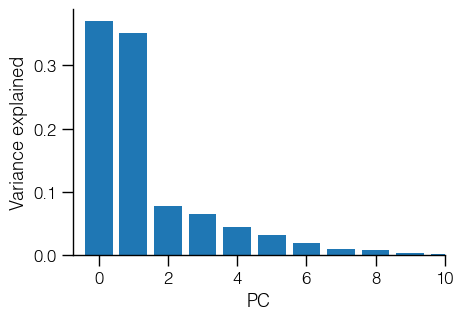

In [16]:
scale = 0.8
fig, axs = plt.subplots(1, 1, figsize=(6 * scale, 4 * scale))

explained_variance_ratios = pca.explained_variance_ratio_
axs.bar(np.arange(explained_variance_ratios.shape[0]), explained_variance_ratios)
axs.set_xlim(-0.75, 10)
axs.set_ylabel('Variance explained')
axs.set_xlabel('PC')
format_plot(axs)

[<Axes: xlabel='Time'> <Axes: xlabel='Time', ylabel='PC'>]


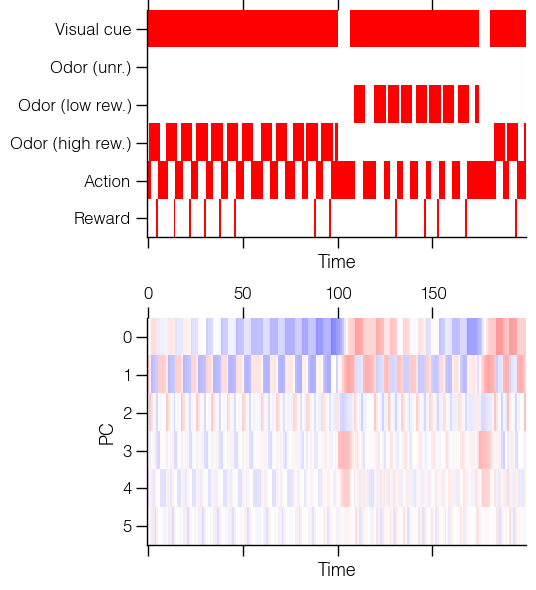

In [17]:
window = slice(1800, 2000)

scale = 1
fig, axs = plt.subplots(2, 1, figsize=(6 * scale, 6 * scale), sharex=True)
axs[1].matshow(pc_activities[:6, 0, window], cmap='bwr', vmin=-1, vmax=1, aspect=20)
axs[1].set_ylabel('PC')
axs[1].set_xlabel('Time')

inputs = np.concatenate([all_session_data[0]['obs'][window, :], all_session_data[0]['action'][window, np.newaxis], all_session_data[0]['reward'][window, np.newaxis]], axis=1).T
axs[0].matshow(inputs, cmap='bwr', vmin=-1, vmax=1, aspect=20)
axs[0].set_yticks(np.arange(6), ['Visual cue', 'Odor (unr.)', 'Odor (low rew.)', 'Odor (high rew.)', 'Action', 'Reward'])
axs[0].set_xlabel('Time')

format_plot(axs)
fig.tight_layout()

In [113]:
def compute_fixed_points(network, inputs):
    fpf_hps = {
    		'max_iters': 50000,
    		'lr_init': 1e-6,
            'tol_q': 1e-10,
    		'outlier_distance_scale': 10.0,
    		'verbose': False, 
    		'super_verbose': False,
    }
    
    network.rnn.batch_first = True
    fpf = FixedPointFinder(network.rnn, **fpf_hps)
    
    # Study the system in the absence of input pulses (e.g., all inputs are 0)
    n_initial_states = 200
    flattened_hidden = hidden_activities.reshape(hidden_activities.shape[0], hidden_activities.shape[1] * hidden_activities.shape[2])
    print(flattened_hidden.shape)
    samples = np.zeros(flattened_hidden.shape[1]).astype(bool)
    samples[:n_initial_states] = True
    np.random.shuffle(samples)
    initial_states = flattened_hidden[:, samples].T
    initial_states = np.array(initial_states)
    # Run the fixed point finder
    unique_fps, all_fps = fpf.find_fixed_points(copy(initial_states), copy(inputs))
    return unique_fps

In [136]:
def plot_eigenvecs_and_vals(unique_fps, env_idx=0):
    scale = 1.2
    fig, axs = plt.subplots(2, 2, figsize=(9 * scale, 7 * scale))

    largest_eigenval_global = np.max(np.real(unique_fps.eigval_J_xstar[:, 0]))
    
    for k in np.arange(0, 8, 2):
        all_mask_off = []
        k_x, k_y = int(k/4), int(k/2) % 2
        
        axs[k_x, k_y].scatter(
            pc_activities[k, env_idx, :],
            pc_activities[k+1, env_idx, :],
            s=1,
            zorder=-1,
            c='grey',
            alpha=0.05,
        )
    
        for i in range(unique_fps.xstar.shape[0]):
            fp_dim_k = np.dot(unique_fps.xstar[i, :], pca.components_[k, :])
            fp_dim_k_plus_1 = np.dot(unique_fps.xstar[i, :], pca.components_[k+1, :])
            
            largest_eigenvec = unique_fps.eigvec_J_xstar[i, :, 0]
    
            largest_real_part_eigen_val = np.real(unique_fps.eigval_J_xstar[i, 0])
    
            
            cbar = axs[k_x, k_y].plot(
                [fp_dim_k, fp_dim_k + np.dot(largest_eigenvec, pca.components_[k, :]) *  np.absolute(unique_fps.eigval_J_xstar[i, 0]) * 0.1],
                [fp_dim_k_plus_1, fp_dim_k_plus_1 + np.dot(largest_eigenvec, pca.components_[k+1, :]) * np.absolute(unique_fps.eigval_J_xstar[i, 0]) * 0.1],
                color='black', #largest_real_part_eigen_val,
                # cmap='plasma',
                # vmin=0,
                # vmax=1.2,
                zorder=-1,
            )
    
            cbar = axs[k_x, k_y].scatter(
                [fp_dim_k],
                [fp_dim_k_plus_1],
                c=largest_real_part_eigen_val,
                cmap='cool',
                s=5,
                vmin=0,
                vmax=1.1,
            )
    
        cbar_ax = fig.colorbar(cbar)
        format_plot(cbar_ax.ax, rightspine=False, leftspine=False, topspine=False, bottomspine=False)
        cbar_ax.outline.set_visible(False)
        cbar_ax.set_label('Real part largest eigenvalue', rotation=270, labelpad=20)
    
        # axs[int(k/2)].set_aspect('equal')
    # fig.legend(markerscale=10, bbox_to_anchor=(0.97, 0.99))
    fig.tight_layout()
    format_pc_plot(axs)

In [137]:
def plot_eigenval_ratio(unique_fps, env_idx=0):
    scale = 1.2
    fig, axs = plt.subplots(2, 2, figsize=(9 * scale, 7 * scale))
    
    for k in np.arange(0, 8, 2):
        all_mask_off = []
        k_x, k_y = int(k/4), int(k/2) % 2
        
        axs[k_x, k_y].scatter(
            pc_activities[k, env_idx, :],
            pc_activities[k+1, env_idx, :],
            s=1,
            zorder=-1,
            c='grey',
            alpha=0.05,
        )
    
        for i_states in range(initial_states.shape[0]):
            it = initial_states[i_states, :]
    
        cbar = axs[k_x, k_y].scatter(
            [np.dot(unique_fps.xstar, pca.components_[k, :])],
            [np.dot(unique_fps.xstar, pca.components_[k+1, :])],
            c=np.real(unique_fps.eigval_J_xstar[:, 1]) / np.real(unique_fps.eigval_J_xstar[:, 0]),
            cmap='plasma',
            s=5,
            vmin=0,
            vmax=1,
        )
        
        cbar_ax = fig.colorbar(cbar)
        format_plot(cbar_ax.ax, rightspine=False, leftspine=False, topspine=False, bottomspine=False)
        cbar_ax.outline.set_visible(False)
        cbar_ax.set_label('Ratio real part largest eigenvalues', rotation=270, labelpad=20)
    
        # axs[int(k/2)].set_aspect('equal')
    # fig.legend(markerscale=10, bbox_to_anchor=(0.97, 0.99))
    fig.tight_layout()
    format_pc_plot(axs)

In [118]:
inputs = np.zeros([n_initial_states, OBS_SIZE + ACTION_SIZE + 1])

unique_fps_baseline = compute_fixed_points(network, inputs)

(128, 4200000)
	Freezing model parameters so model is not affected by fixed point optimization.
		initial_states: 0 outliers detected (of 200).
		fixed points: 0 outliers detected (of 199).
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.


Axes(0.424432,0.53;0.0528409x0.35)
Axes(0.847159,0.53;0.0528409x0.35)
Axes(0.424432,0.11;0.0528409x0.35)
Axes(0.847159,0.11;0.0528409x0.35)
[<Axes: > <Axes: > <Axes: > <Axes: >]
[<Axes: xlabel='PC 1', ylabel='PC 2'>, <Axes: xlabel='PC 3', ylabel='PC 4'>, <Axes: xlabel='PC 5', ylabel='PC 6'>, <Axes: xlabel='PC 7', ylabel='PC 8'>]
Axes(0.424432,0.53;0.0528409x0.35)
Axes(0.847159,0.53;0.0528409x0.35)
Axes(0.424432,0.11;0.0528409x0.35)
Axes(0.847159,0.11;0.0528409x0.35)
[<Axes: > <Axes: > <Axes: > <Axes: >]
[<Axes: xlabel='PC 1', ylabel='PC 2'>, <Axes: xlabel='PC 3', ylabel='PC 4'>, <Axes: xlabel='PC 5', ylabel='PC 6'>, <Axes: xlabel='PC 7', ylabel='PC 8'>]


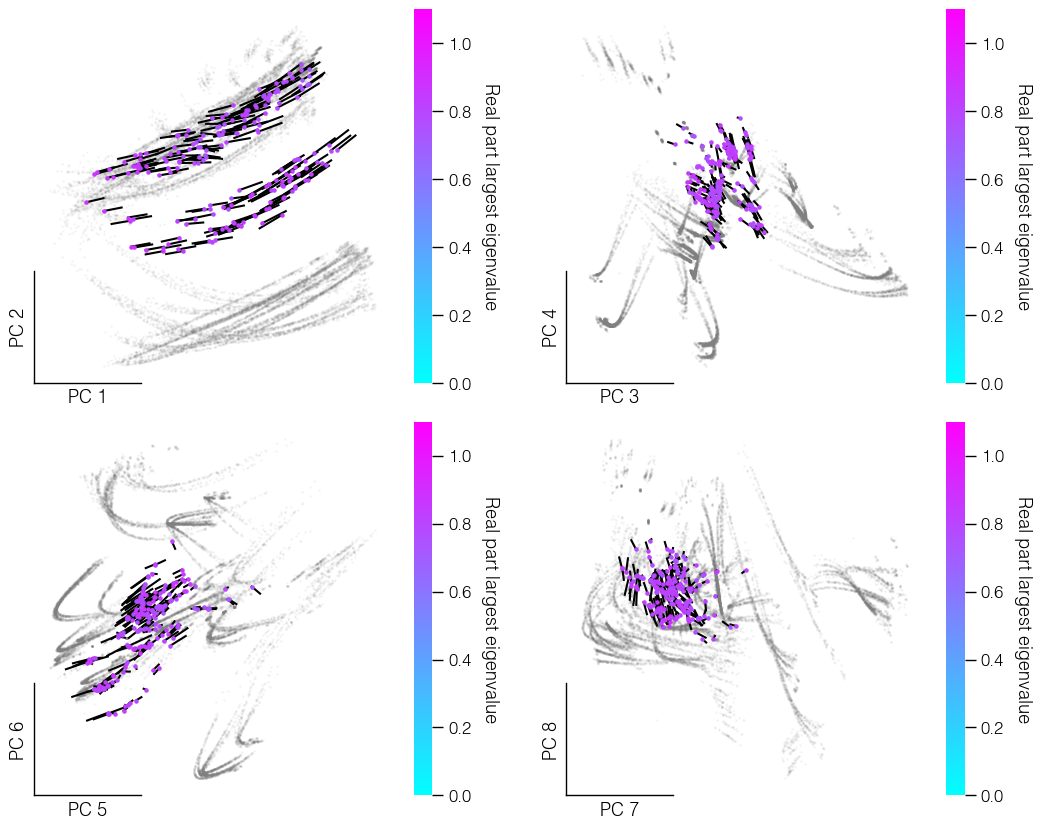

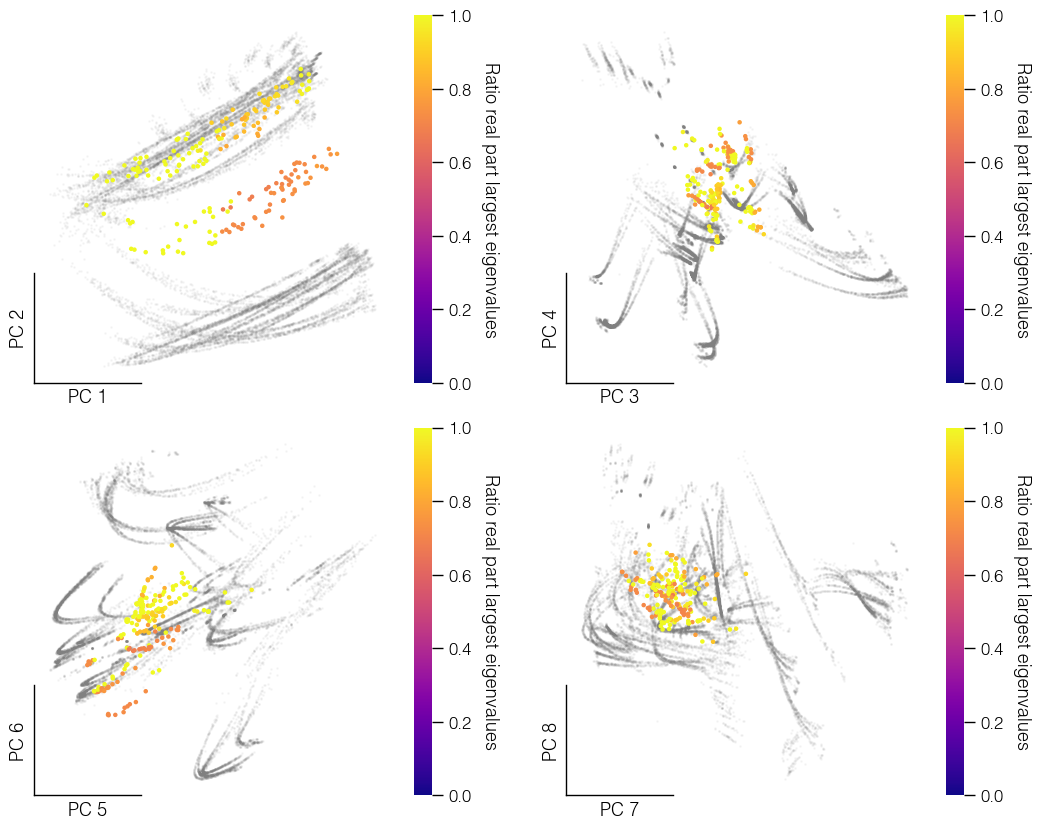

In [138]:
plot_eigenvecs_and_vals(unique_fps_baseline)
plot_eigenval_ratio(unique_fps_baseline)

In [120]:
inputs = np.zeros([n_initial_states, OBS_SIZE + ACTION_SIZE + 1])
inputs[:, 0] = 1

unique_fps_visual_input = compute_fixed_points(network, inputs)

(128, 4200000)
	Freezing model parameters so model is not affected by fixed point optimization.
		initial_states: 0 outliers detected (of 200).
		fixed points: 0 outliers detected (of 200).
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.


Axes(0.424432,0.53;0.0528409x0.35)
Axes(0.847159,0.53;0.0528409x0.35)
Axes(0.424432,0.11;0.0528409x0.35)
Axes(0.847159,0.11;0.0528409x0.35)
[<Axes: > <Axes: > <Axes: > <Axes: >]
[<Axes: xlabel='PC 1', ylabel='PC 2'>, <Axes: xlabel='PC 3', ylabel='PC 4'>, <Axes: xlabel='PC 5', ylabel='PC 6'>, <Axes: xlabel='PC 7', ylabel='PC 8'>]
Axes(0.424432,0.53;0.0528409x0.35)
Axes(0.847159,0.53;0.0528409x0.35)
Axes(0.424432,0.11;0.0528409x0.35)
Axes(0.847159,0.11;0.0528409x0.35)
[<Axes: > <Axes: > <Axes: > <Axes: >]
[<Axes: xlabel='PC 1', ylabel='PC 2'>, <Axes: xlabel='PC 3', ylabel='PC 4'>, <Axes: xlabel='PC 5', ylabel='PC 6'>, <Axes: xlabel='PC 7', ylabel='PC 8'>]


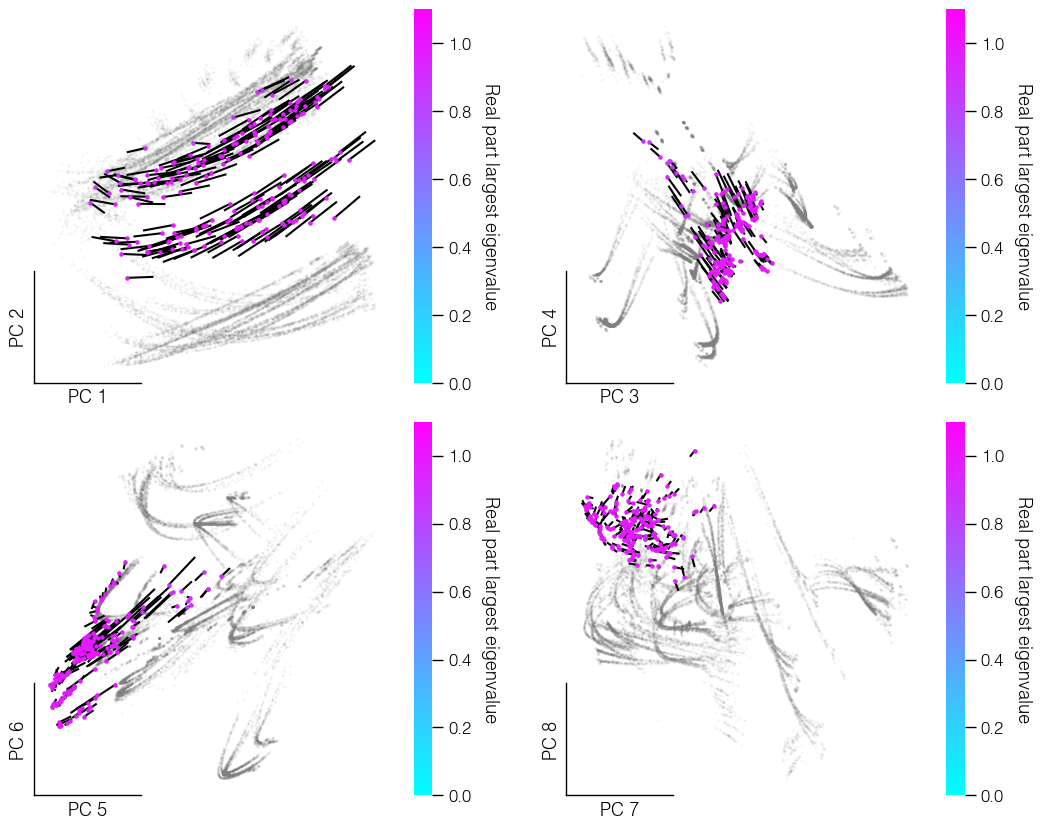

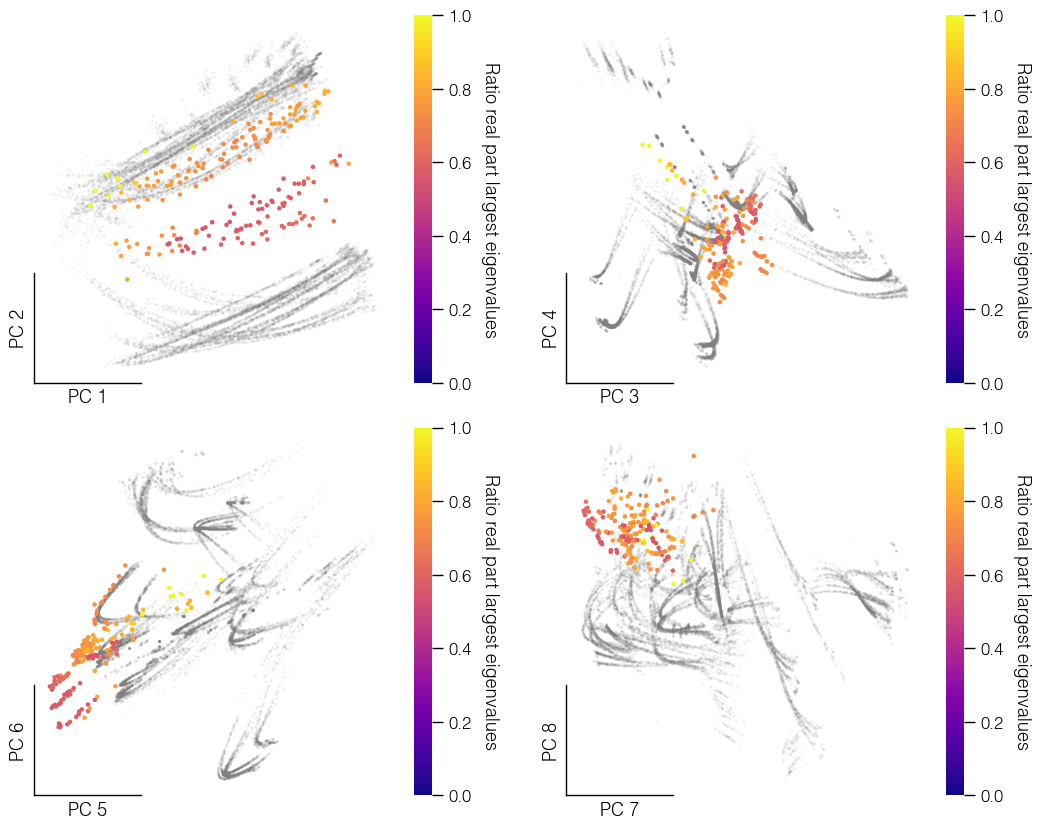

In [139]:
plot_eigenvecs_and_vals(unique_fps_visual_input)
plot_eigenval_ratio(unique_fps_visual_input)

In [122]:
inputs = np.zeros([n_initial_states, OBS_SIZE + ACTION_SIZE + 1])
inputs[:, 0] = 1
inputs[:, 2] = 1

unique_fps_low_reward_odor = compute_fixed_points(network, inputs)

(128, 4200000)
	Freezing model parameters so model is not affected by fixed point optimization.
		initial_states: 0 outliers detected (of 200).
		fixed points: 0 outliers detected (of 200).
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.


Axes(0.424432,0.53;0.0528409x0.35)
Axes(0.847159,0.53;0.0528409x0.35)
Axes(0.424432,0.11;0.0528409x0.35)
Axes(0.847159,0.11;0.0528409x0.35)
[<Axes: > <Axes: > <Axes: > <Axes: >]
[<Axes: xlabel='PC 1', ylabel='PC 2'>, <Axes: xlabel='PC 3', ylabel='PC 4'>, <Axes: xlabel='PC 5', ylabel='PC 6'>, <Axes: xlabel='PC 7', ylabel='PC 8'>]
Axes(0.424432,0.53;0.0528409x0.35)
Axes(0.847159,0.53;0.0528409x0.35)
Axes(0.424432,0.11;0.0528409x0.35)
Axes(0.847159,0.11;0.0528409x0.35)
[<Axes: > <Axes: > <Axes: > <Axes: >]
[<Axes: xlabel='PC 1', ylabel='PC 2'>, <Axes: xlabel='PC 3', ylabel='PC 4'>, <Axes: xlabel='PC 5', ylabel='PC 6'>, <Axes: xlabel='PC 7', ylabel='PC 8'>]


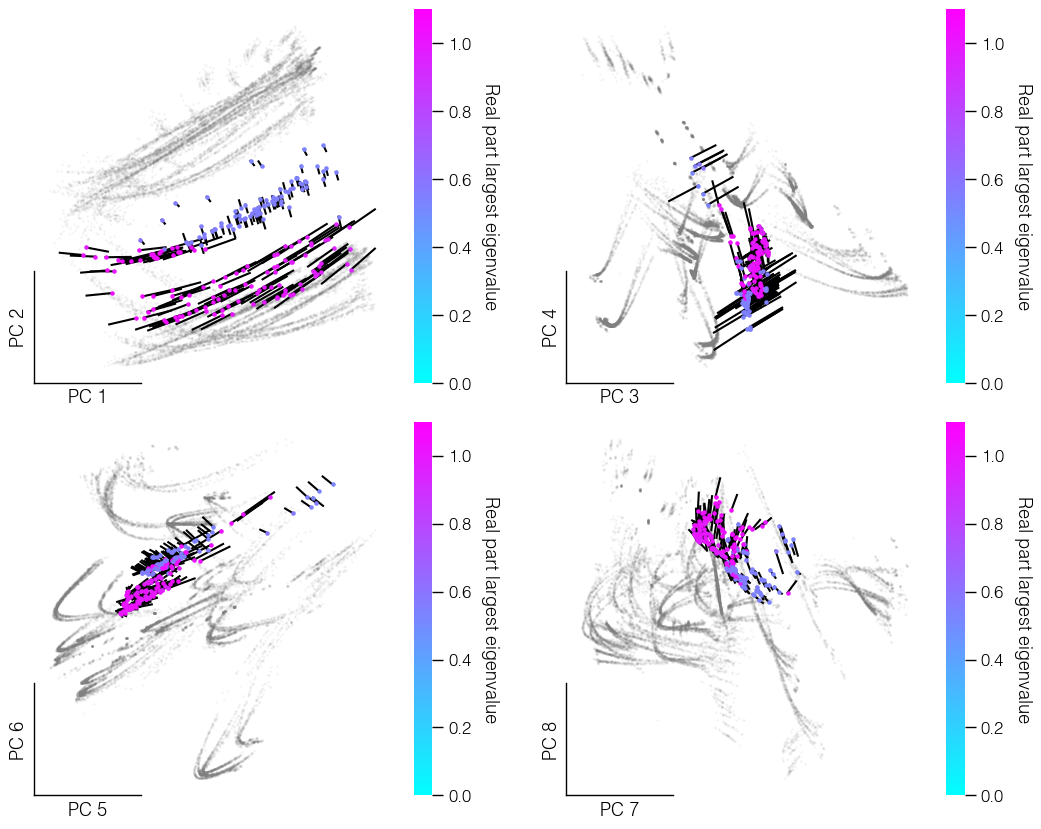

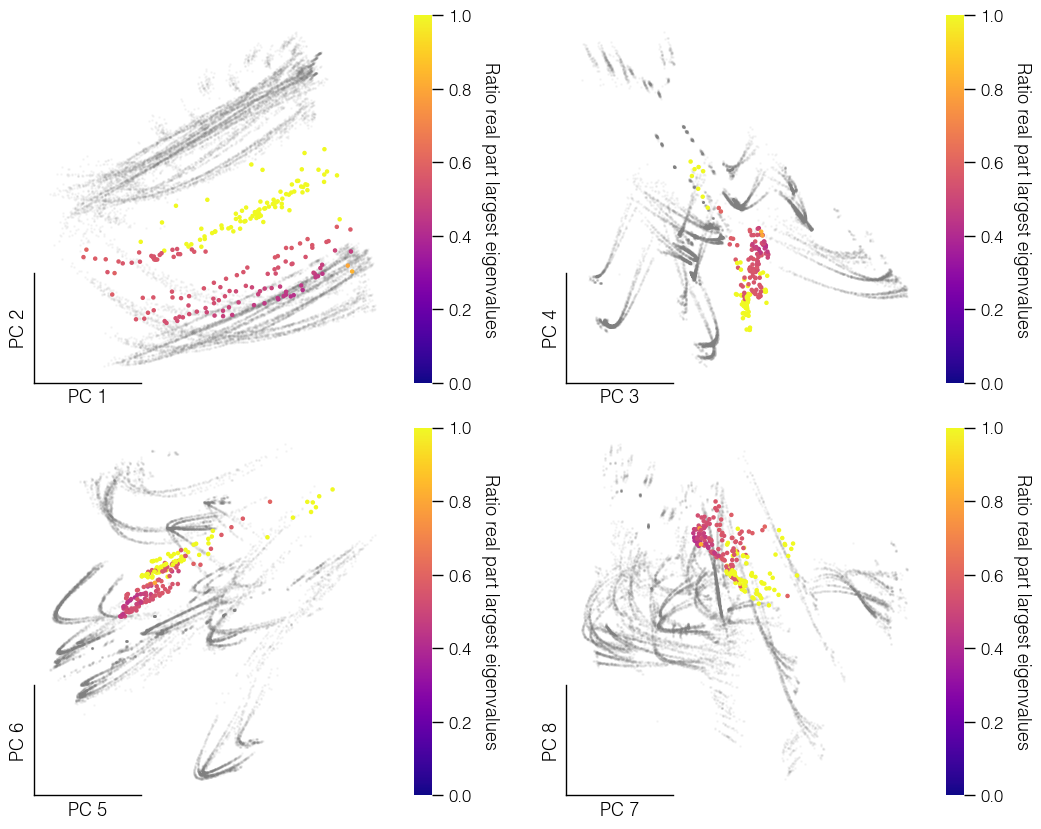

In [140]:
plot_eigenvecs_and_vals(unique_fps_low_reward_odor)
plot_eigenval_ratio(unique_fps_low_reward_odor)

In [124]:
inputs = np.zeros([n_initial_states, OBS_SIZE + ACTION_SIZE + 1])
inputs[:, 0] = 1
inputs[:, 3] = 1

unique_fps_high_reward_odor = compute_fixed_points(network, inputs)

(128, 4200000)
	Freezing model parameters so model is not affected by fixed point optimization.
		initial_states: 0 outliers detected (of 200).
		fixed points: 0 outliers detected (of 200).
	Decomposing Jacobians in a single batch.
	Sorting by Eigenvalue magnitude.


Axes(0.424432,0.53;0.0528409x0.35)
Axes(0.847159,0.53;0.0528409x0.35)
Axes(0.424432,0.11;0.0528409x0.35)
Axes(0.847159,0.11;0.0528409x0.35)
[<Axes: > <Axes: > <Axes: > <Axes: >]
[<Axes: xlabel='PC 1', ylabel='PC 2'>, <Axes: xlabel='PC 3', ylabel='PC 4'>, <Axes: xlabel='PC 5', ylabel='PC 6'>, <Axes: xlabel='PC 7', ylabel='PC 8'>]
Axes(0.424432,0.53;0.0528409x0.35)
Axes(0.847159,0.53;0.0528409x0.35)
Axes(0.424432,0.11;0.0528409x0.35)
Axes(0.847159,0.11;0.0528409x0.35)
[<Axes: > <Axes: > <Axes: > <Axes: >]
[<Axes: xlabel='PC 1', ylabel='PC 2'>, <Axes: xlabel='PC 3', ylabel='PC 4'>, <Axes: xlabel='PC 5', ylabel='PC 6'>, <Axes: xlabel='PC 7', ylabel='PC 8'>]


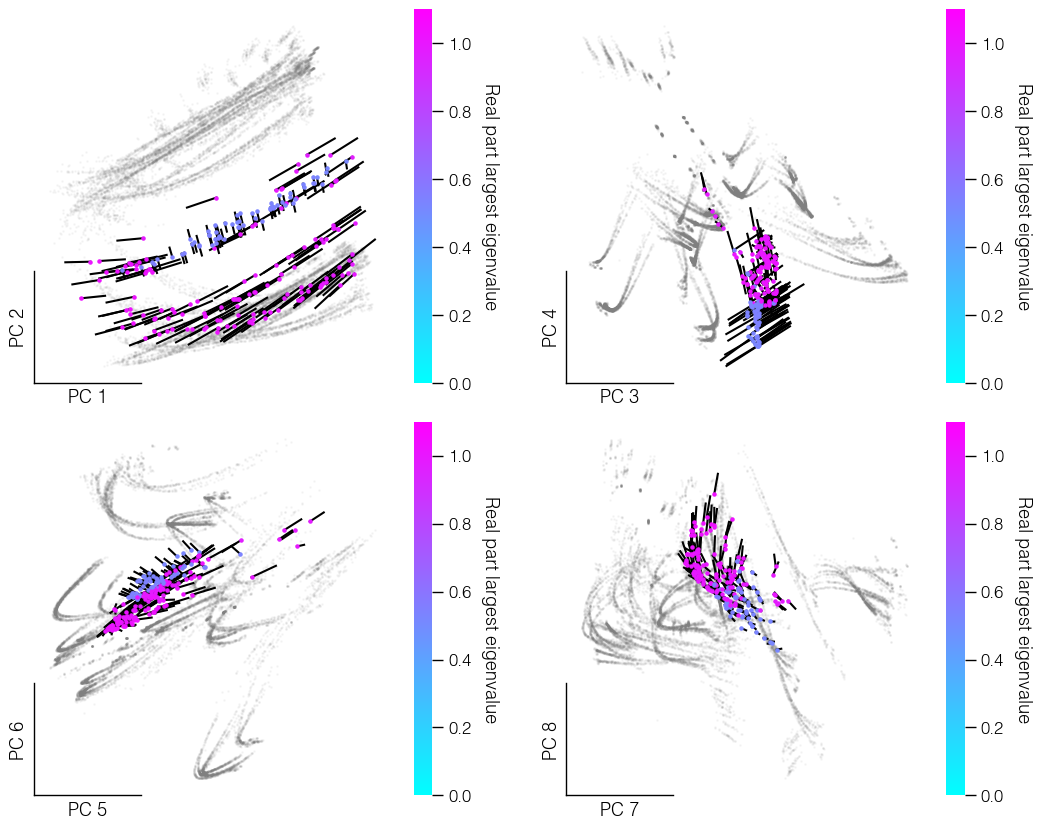

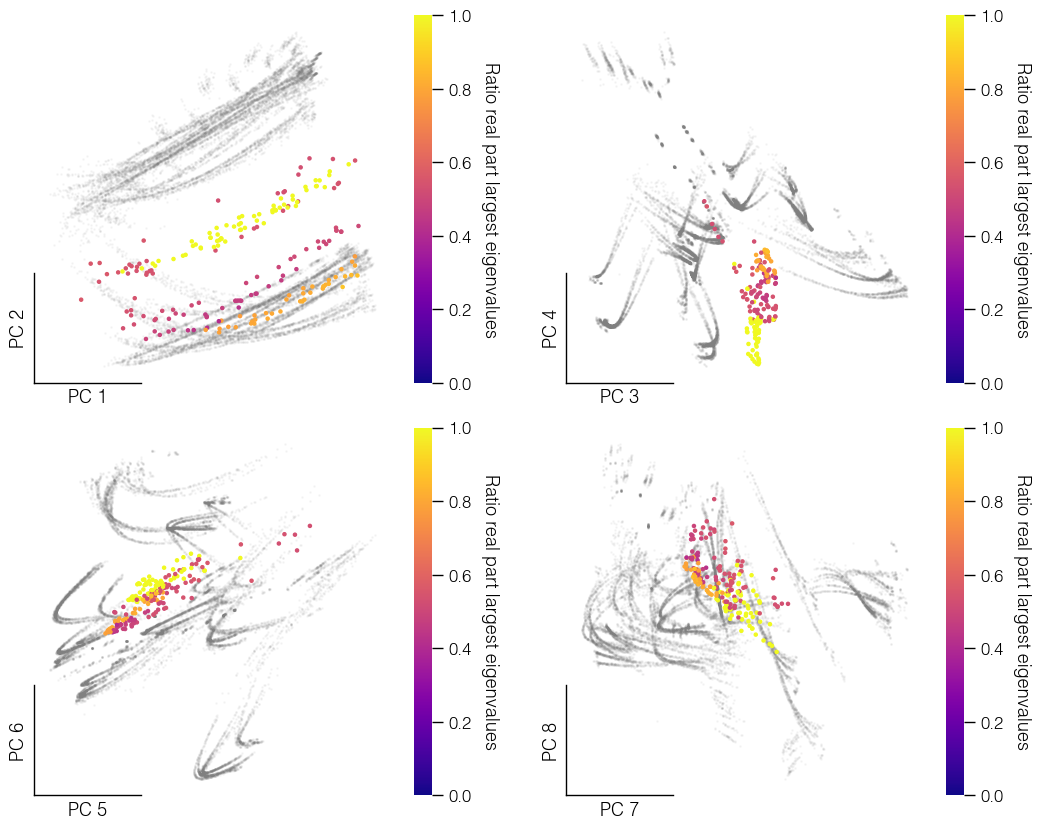

In [141]:
plot_eigenvecs_and_vals(unique_fps_high_reward_odor)
plot_eigenval_ratio(unique_fps_high_reward_odor)